In [1]:
import matplotlib
matplotlib.use('Agg')

%matplotlib inline
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import seaborn as sns; sns.set()
import numpy as np
from sklearn.mixture import GaussianMixture
import pickle
import pandas as pd
from multiprocessing import Pool, Array, Process
from multiprocessing import cpu_count

#import ctypes


# Load Data

In [3]:
df = pd.read_hdf('./training_data/Mt_Bolton_height.h5')

Data generated from raw volumes with some QC. See notebook: 
```Generate data for clustering models - Mt Bolton```

# Plot KDEs of Radar Data
Calculating the KDE is slow, but should only need to be done once.

CPU times: user 6h 55min 59s, sys: 4h 56min 11s, total: 11h 52min 11s
Wall time: 11h 55min 47s


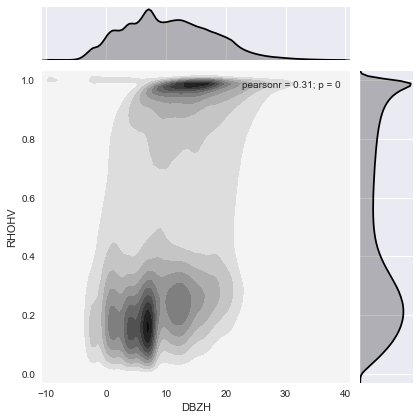

In [22]:
%%time
sns.jointplot(x=df.DBZH, y=df.RHOHV, kind='kde',color="k")

CPU times: user 6h 41min 5s, sys: 4h 58min 26s, total: 11h 39min 32s
Wall time: 1d 6h 21min 25s


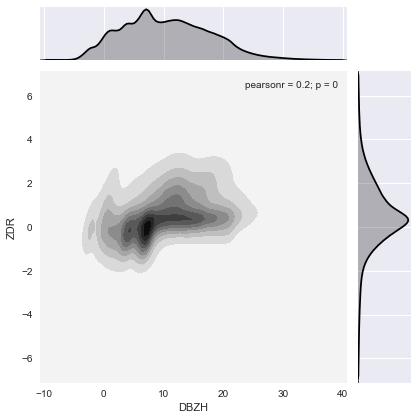

In [23]:
%%time
sns.jointplot(x=df.DBZH, y=df.ZDR, kind='kde',color="k")

CPU times: user 6h 24min 49s, sys: 5h 11min 27s, total: 11h 36min 17s
Wall time: 11h 40min 36s


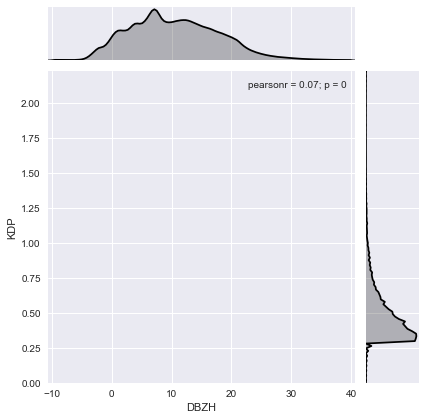

In [24]:
%%time
sns.jointplot(x=df.DBZH, y=df.KDP, kind='kde',color="k")

In [ ]:
%%time
sns.jointplot(x=df.DBZH, y=df.WRADH, kind='kde',color="k")

CPU times: user 6h 39min 43s, sys: 4h 46min 31s, total: 11h 26min 15s
Wall time: 11h 27min 27s


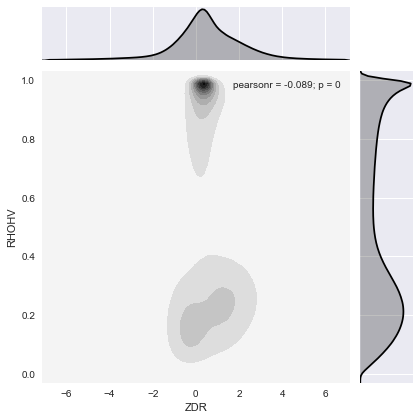

In [25]:
%%time
sns.jointplot(x=df.ZDR, y=df.RHOHV, kind='kde',color="k")

In [ ]:
%%time
sns.jointplot(x=df.DBZH, y=df.ALT, kind='kde',color="k")

# Train Models

Models are trained in remotely in parallel using the script `./nci_fit_GMM.py`, using full variance for the component range 4 to 20. This script pickles (saves) the results which are loaded here.

# Load Models

In [278]:
models_fn = './models/Mt_Bolton_altitude_4_12.gmm'
models = pickle.load(open(models_fn, 'rb'))
models = sorted(models, key=lambda k: k.n_components) 

# Plot AIC/BIC

AIC and BIC are calculated with the script `nci_calculate_AIC_BIC.py` in parrallel on NCI. 

They are saved in a list format as `[AIC value, No of components]`.

In [188]:
saved_AIC = './Mt_Bolton_altitude_4_12.aic'
saved_BIC = './Mt_Bolton_altitude_4_12.bic'

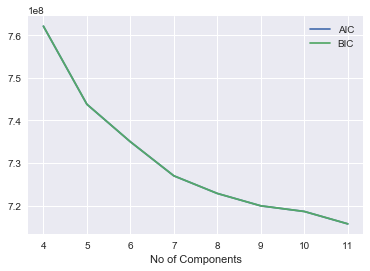

In [189]:
AIC, BIC = pickle.load(open(saved_AIC, 'rb')), pickle.load(open(saved_BIC, 'rb'))

plt.plot([AIC[n][1] for n in range(len(AIC))], [AIC[n][0] for n in range(len(AIC))], label='AIC')
plt.plot([BIC[n][1] for n in range(len(AIC))], [BIC[n][0] for n in range(len(AIC))], label='BIC')
plt.legend(loc='best')
plt.xlabel('No of Components');

# Plot GMM Scatterplots with Variance Ellipses

In [1]:
from helper_functions.cluster_plots import plot_gmm_scatter
plot_gmm_scatter(models[4], df.sample(n).values,x_var=0,y_var=1)

/Users/nick/anaconda3/envs/radytheon27/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


NameError: global name 'df' is not defined

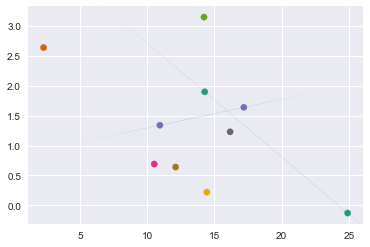

In [9]:
plot_gmm_scatter(models[4], df.sample(n).values,x_var=0,y_var=1)

In [37]:
from scipy.spatial.distance import cdist
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    
    ax = ax or plt.gca()
    #print(covariance)
    
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    #print(width)
    #print(height)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
        
def plot_gmm(gmm, X, label=True, ax=None, x_var=0, y_var=1):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax = ax.scatter(X[:, x_var], X[:, y_var], c=labels, s=40, cmap='Dark2', zorder=2)
    else:
        ax = ax.scatter(X[:, x_var], X[:, y_var], s=40, zorder=2)
    #ax.axis('equal')
    
    plt.legend(loc='lower right')
    
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_[:,[x_var,y_var]], gmm.covariances_[:,[x_var,y_var]], gmm.weights_):
        draw_ellipse(pos, covar[:,[x_var,y_var]], alpha=w * w_factor)
        
    #ax.set_ylim(-10., 10.)
    plt.ylabel(list(df)[y_var])
    plt.xlabel(list(df)[x_var])
    

    #legend = ax.get_legend()
    plt.legend()
    #plt.legend(colors,loc='lower right')

## Set no. of random samples for scatterplot

In [38]:
n = 5000

## All variables against dBZ

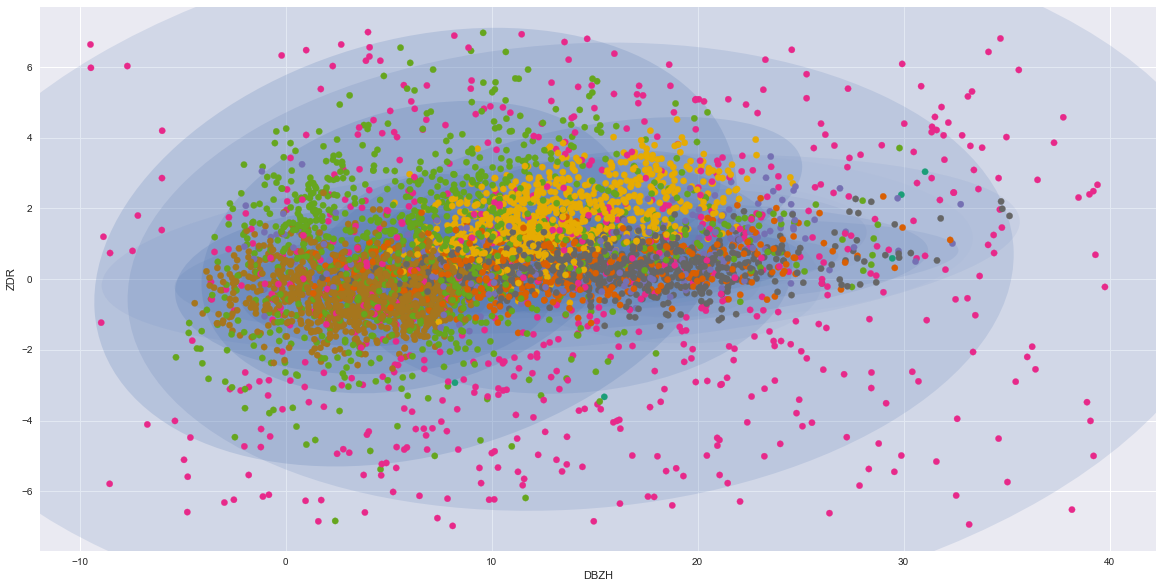

In [23]:
plot_gmm(models[7], df.sample(n).values,x_var=0,y_var=1)

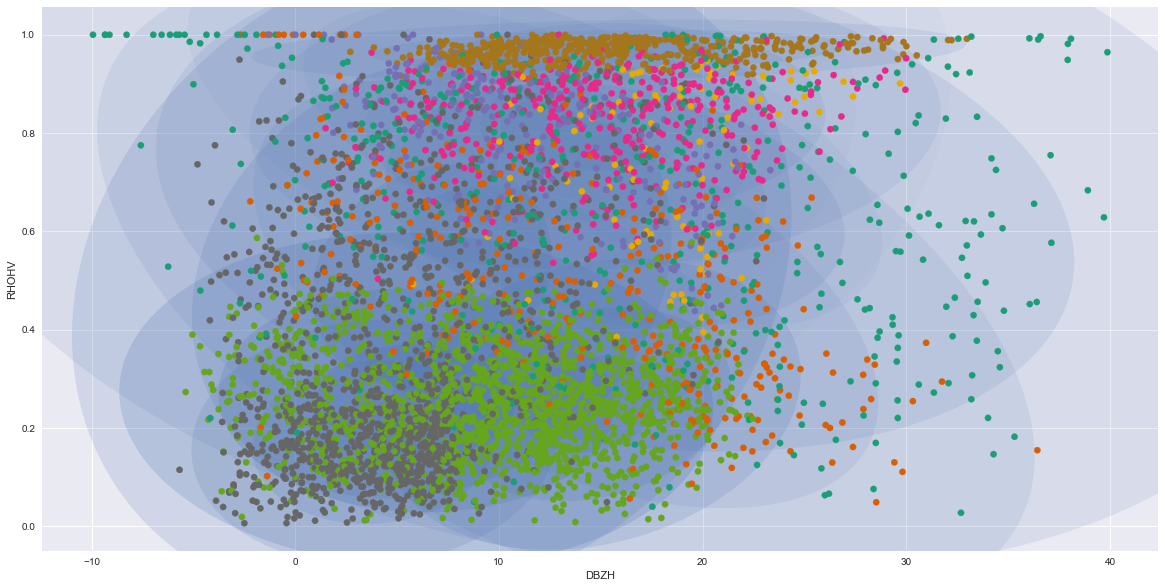

In [24]:
plot_gmm(models[7], df.sample(n).values,x_var=0,y_var=2)

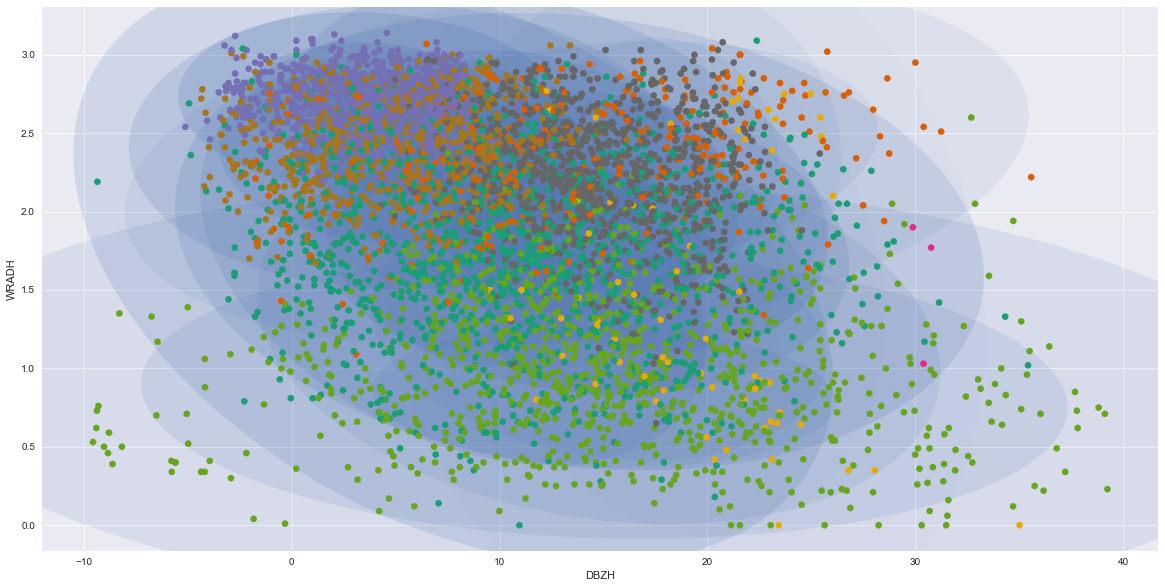

In [25]:
plot_gmm(models[7], df.sample(n).values,x_var=0,y_var=3)

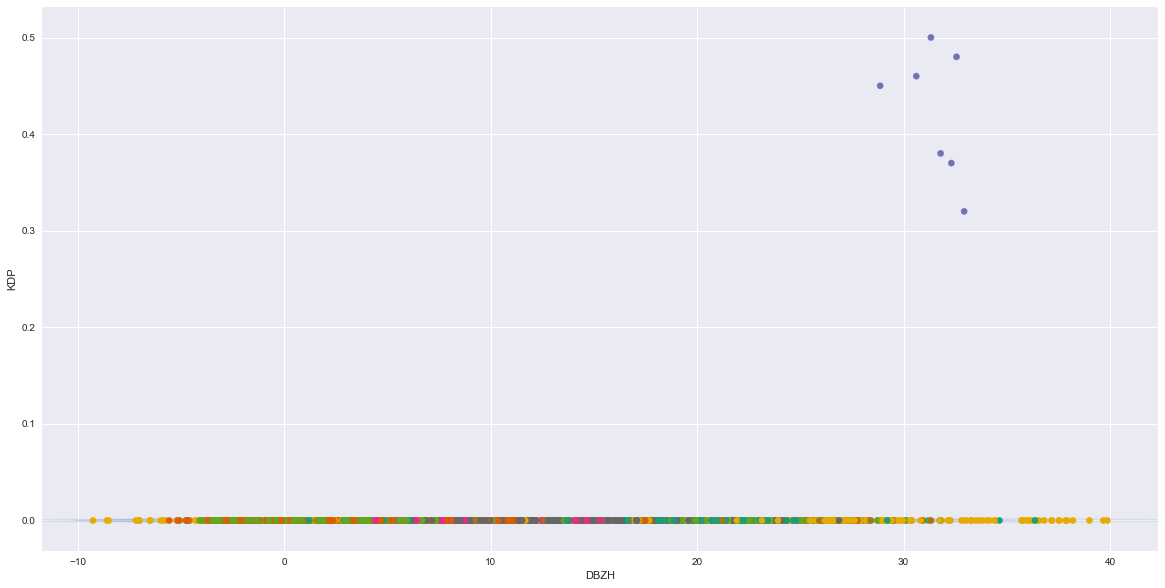

In [26]:
plot_gmm(models[7], df.sample(n).values,x_var=0,y_var=4)

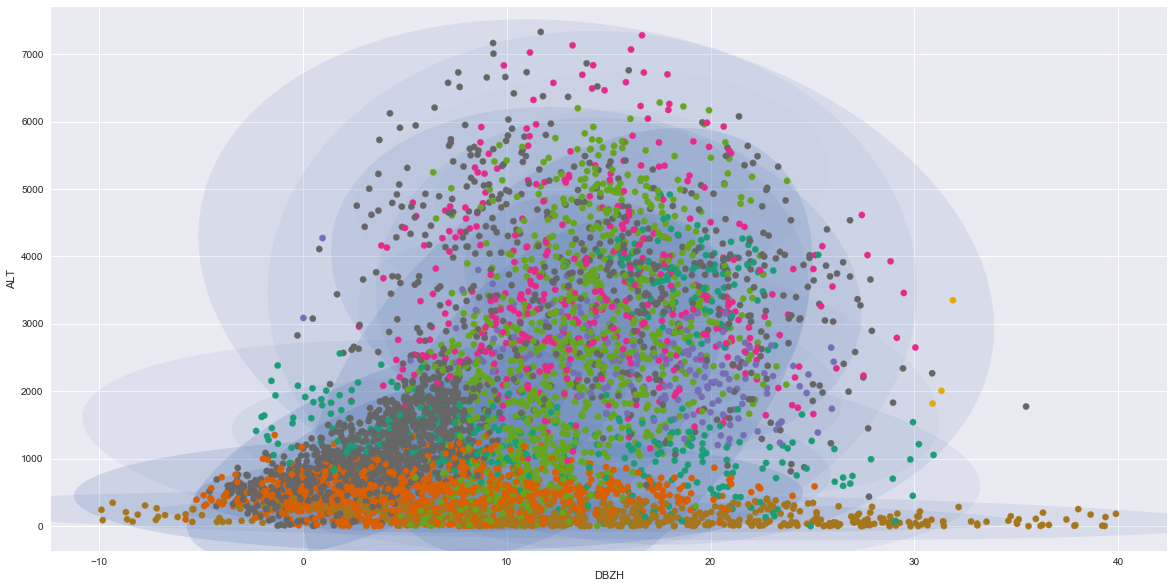

In [27]:
plot_gmm(models[7], df.sample(n).values,x_var=0,y_var=5)

## ZDR vs RhoHV

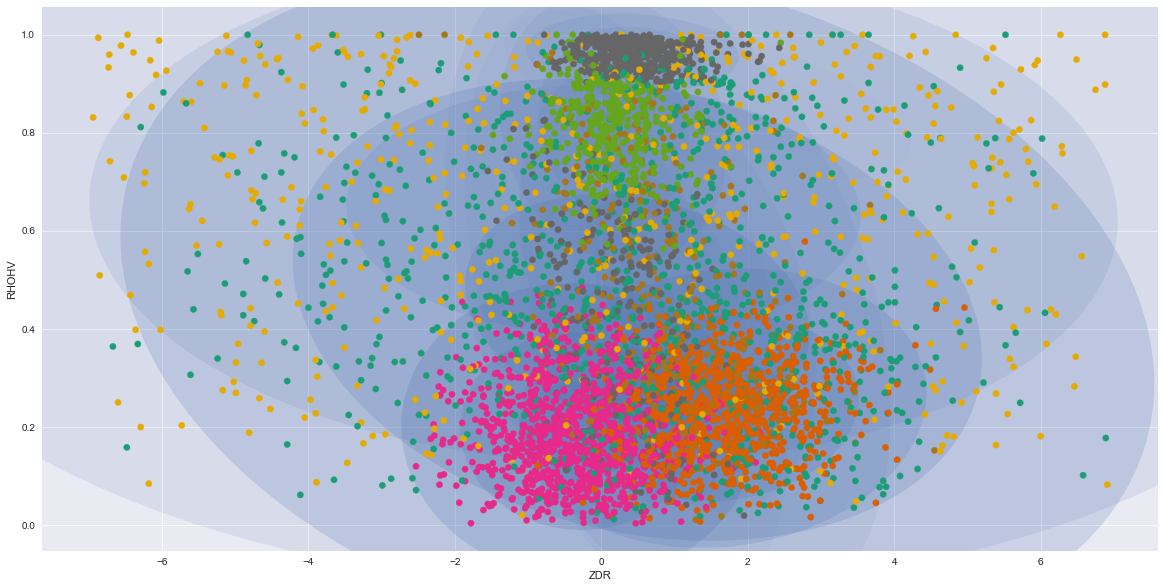

In [29]:
plot_gmm(models[7], df.sample(n).values,x_var=1,y_var=2)

In [30]:
len(models)

8

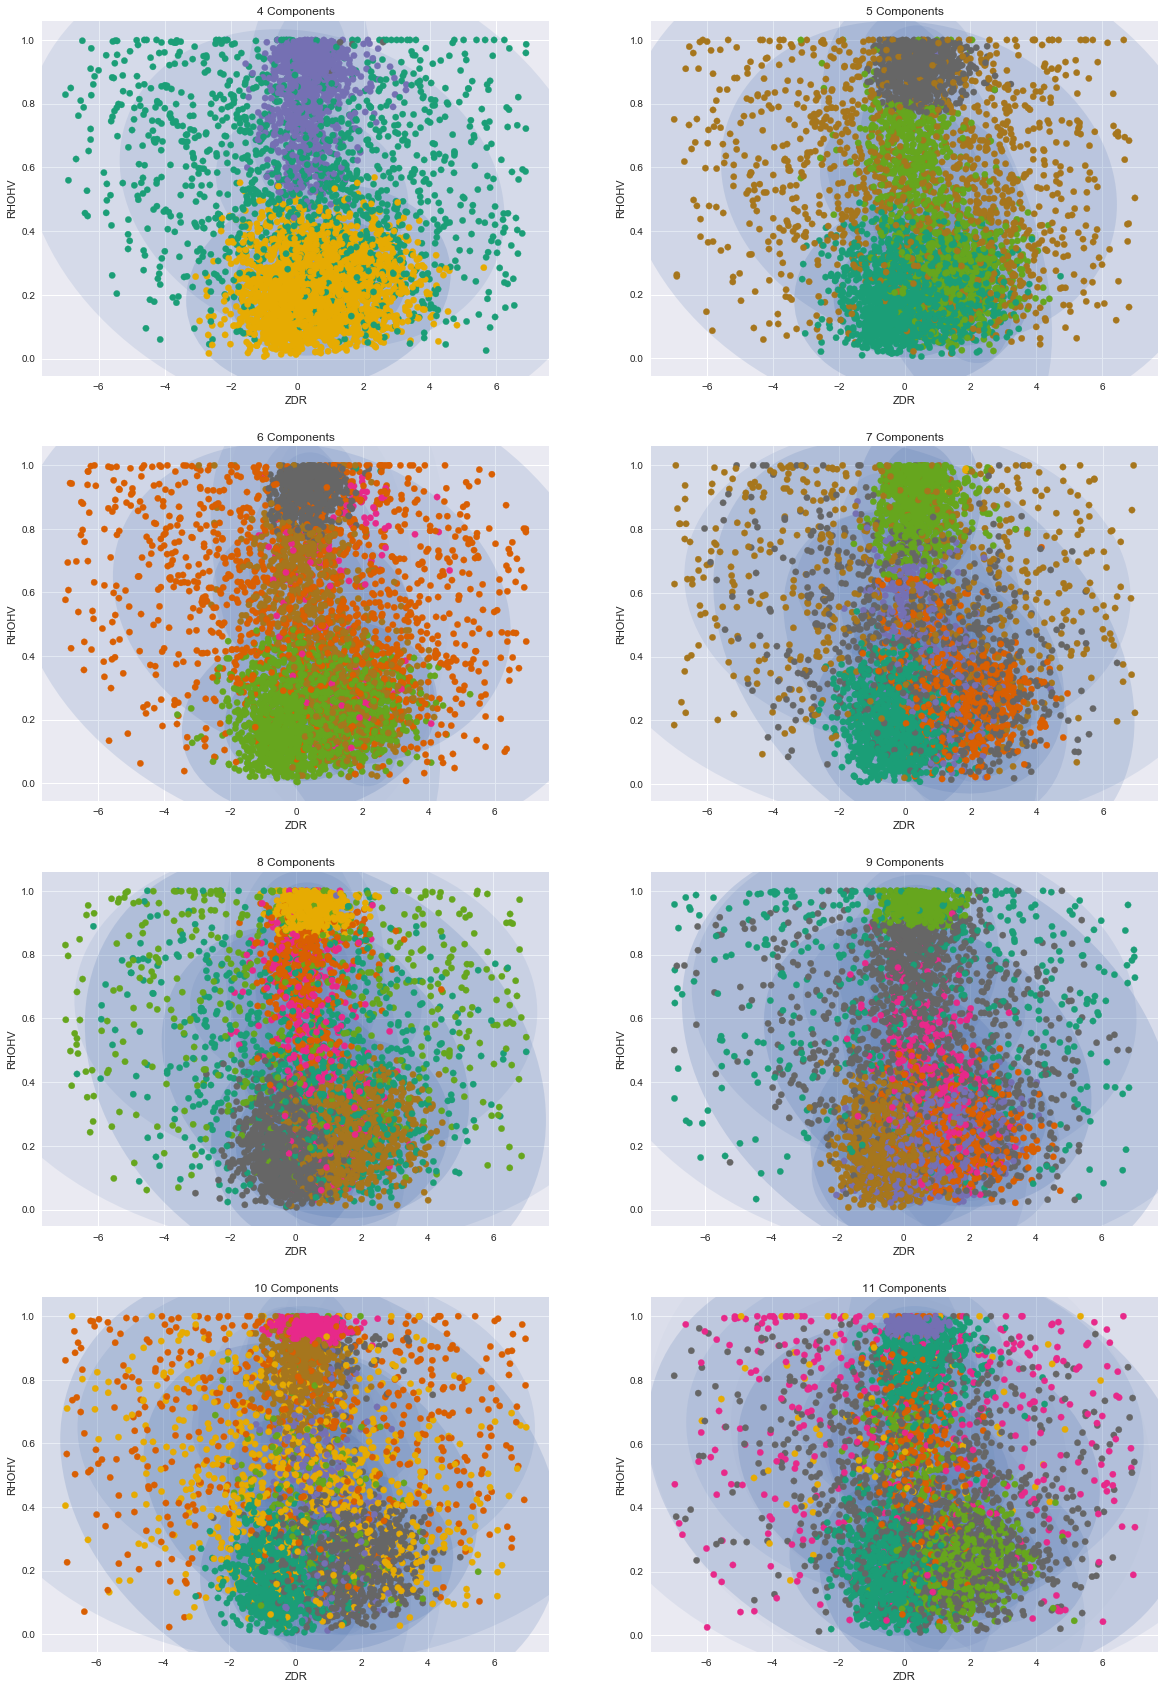

In [43]:
plt.figure(figsize=(20,30))
for x in range(8):
    plt.subplot(4,2,x+1)
    plot_gmm(models[x], df.sample(n).values,x_var=1,y_var=2)
    plt.title(str(models[x].n_components) + ' Components')

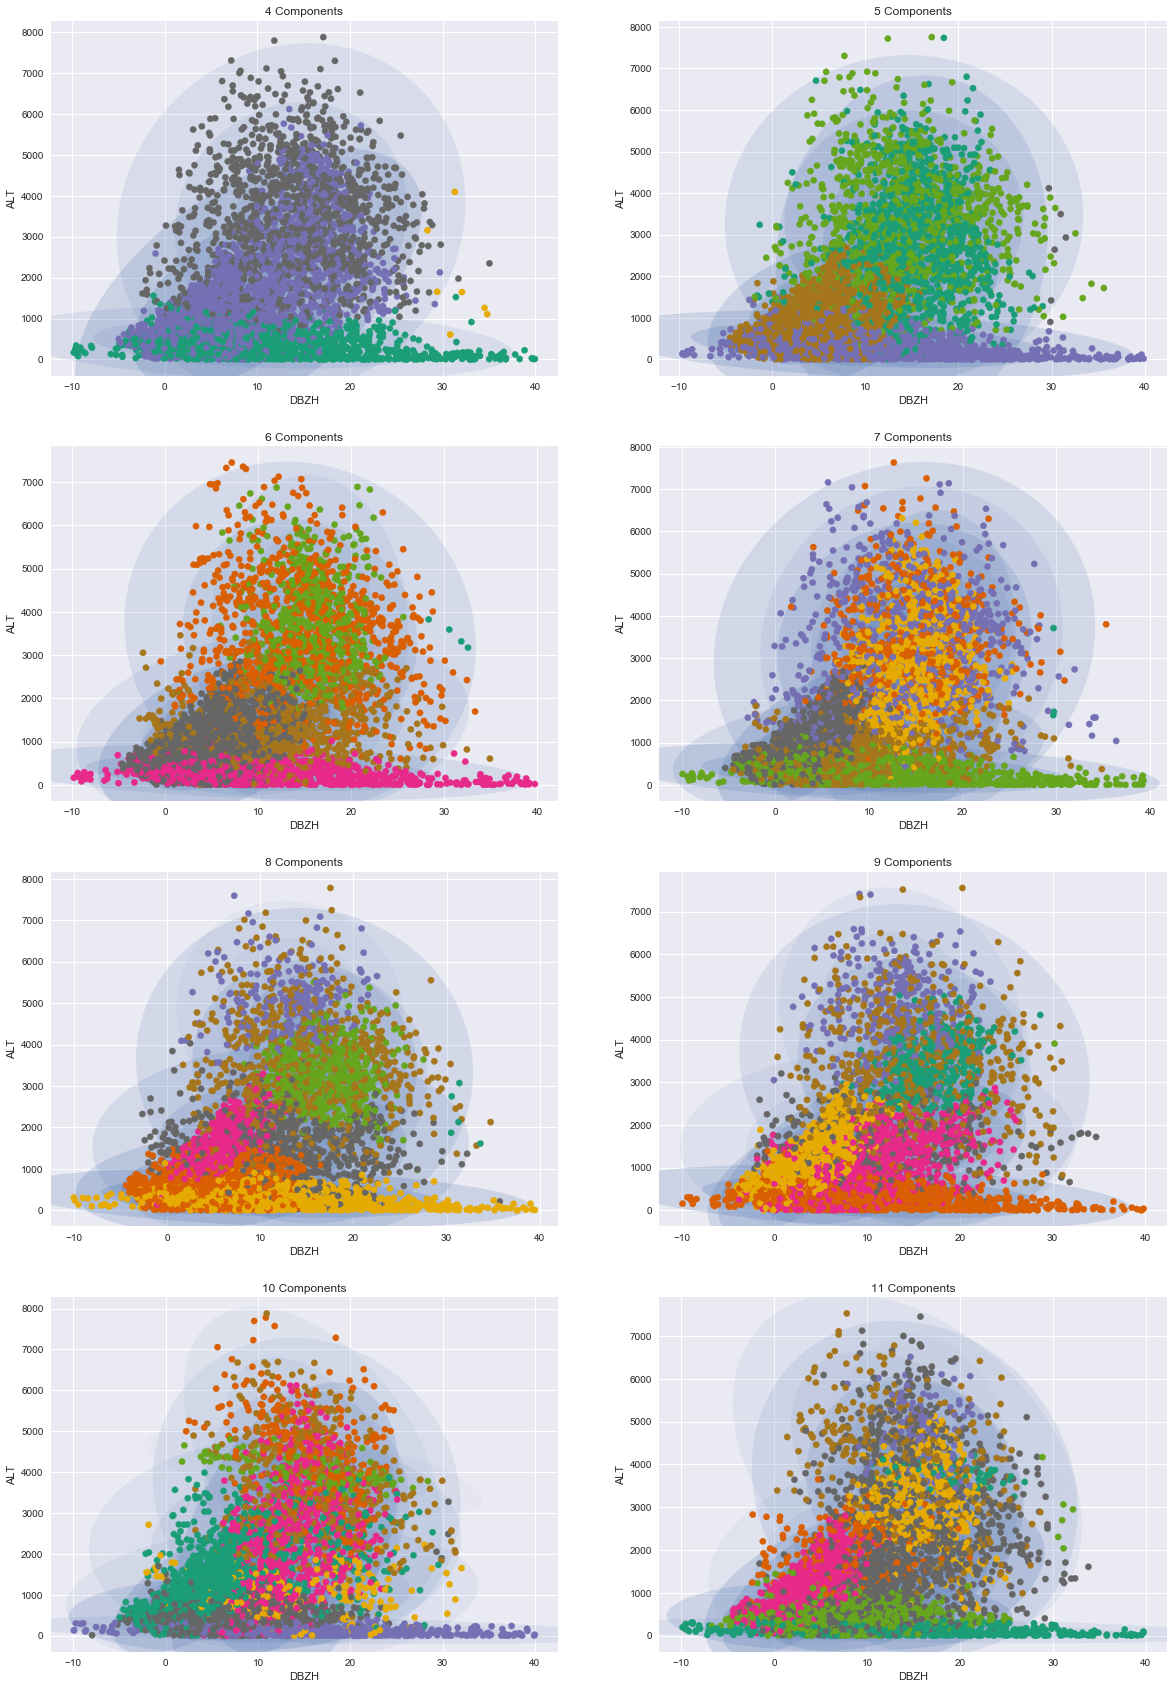

In [44]:
plt.figure(figsize=(20,30))
for x in range(8):
    plt.subplot(4,2,x+1)
    plot_gmm(models[x], df.sample(n).values,x_var=0,y_var=5)
    plt.title(str(models[x].n_components) + ' Components')

In [270]:
means = pd.DataFrame(models[0].means_,columns=list(df))
means['cluster_no'] = range(1,len(means)+1)

In [271]:
means

DBZH       ZDR     RHOHV     WRADH       KDP          ALT  cluster_no
0  31.132470  1.411647  0.964316  1.287323  0.469261  2367.178543           1
1  14.521647  0.497871  0.753924  1.778932  0.000000  3285.728115           2
2  10.312161  0.423555  0.539172  1.485272  0.000000   360.541774           3
3   7.636534  0.559201  0.214547  2.465828  0.000000  1352.792922           4

# Plot Spider Graphs of Cluster Means

In [7]:
def spider(mod_no,df,centers=None):
    from helper_functions.cluster_plots import prep_spider, ComplexSpider
    from helper_functions.cmap import discrete_cmap
    
    ranges = {'DBZH':[0.,50],
        'ZDR':[-3,2],
        'RHOHV':[0.,1.],
        'WRADH':[0.,2.8],
        'KDP':[0.,1.],
        'ALT':[0.,5000.]}
    offsets = {'DBZH':0.,
            'ZDR':7.,
            'zero':1e-6}
    #Select model
    #mod_no = 7

    #Extract means from model
    means = pd.DataFrame(models[mod_no].means_.copy(),columns=list(df))
    k = models[mod_no].n_components

    #Generate discrete cmap
    dcmap = discrete_cmap(k,'pyart_NWSRef')

    #Implement plotting offsets
    means_offset, ranges_offset, label_ranges = prep_spider(means,ranges,offsets)
    
    if centers == None:
        fig1 = plt.figure(figsize=(6, 6))
        radar = ComplexSpider(fig1,
                             [key for key in ranges_offset.iterkeys()],
                             [val for val in ranges_offset.itervalues()],
                             [val for val in label_ranges.itervalues()])

        for n in range(len(means_offset)):
            radar.plot([means_offset[val][n] for val in ranges_offset.iterkeys()],color=dcmap(n))
        plt.show()
    else:
        fig2 = plt.figure(figsize=(6, 6))
        radar = ComplexSpider(fig2,
                             [key for key in ranges_offset.iterkeys()],
                             [val for val in ranges_offset.itervalues()],
                             [val for val in label_ranges.itervalues()])

        for n in centers:
            radar.plot([means_offset[val][n] for val in ranges_offset.iterkeys()],color=dcmap(n))
            radar.fill([means_offset[val][n] for val in ranges_offset.iterkeys()],color=dcmap(n),alpha=0.05)
        plt.show()

In [3]:
df = pd.read_hdf('./training_data/Mt_Bolton_height_185.h5')

In [4]:
ranges = {'DBZH':[0.,50],
        'ZDR':[-3,2],
        'RHOHV':[0.,1.],
        'WRADH':[0.,2.8],
        'KDP':[0.,1.],
        'ALT':[0.,5000.]}
offsets = {'DBZH':0.,
        'ZDR':7.,
        'zero':1e-6}

In [5]:
models_fn = './models/Mt_Bolton_altitude_4_12.gmm'

#Load and sort models
models = pickle.load(open(models_fn, 'rb'))
models = sorted(models, key=lambda k: k.n_components)

#Select model
mod_no = 7

#Extract means from model
means = pd.DataFrame(models[mod_no].means_.copy(),columns=list(df))
k = models[mod_no].n_components

#Generate discrete cmap
dcmap = discrete_cmap(k,'pyart_NWSRef')
 
#Implement plotting offsets
means_offset, ranges_offset, label_ranges = prep_spider(means,ranges,offsets)

/Users/nick/anaconda3/envs/radytheon27/lib/python2.7/site-packages/sklearn/base.py:312: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.19.1 when using version 0.19.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


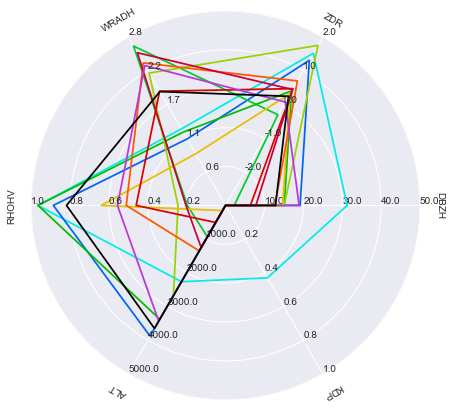

In [6]:
fig1 = plt.figure(figsize=(6, 6))
radar = ComplexSpider(fig1,
                     [key for key in ranges_offset.iterkeys()],
                     [val for val in ranges_offset.itervalues()],
                     [val for val in label_ranges.itervalues()])

for n in range(len(means_offset)):
    radar.plot([means_offset[val][n] for val in ranges_offset.iterkeys()],color=dcmap(n))
plt.show()

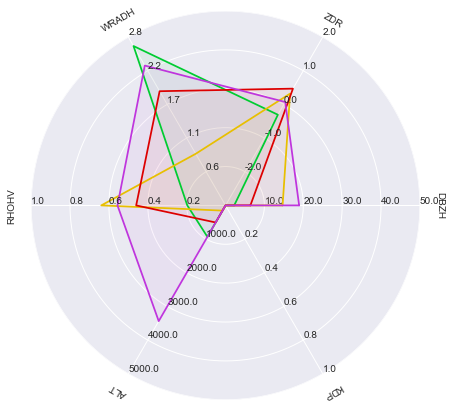

In [7]:
fig2 = plt.figure(figsize=(6, 6))
radar = ComplexSpider(fig2,
                     [key for key in ranges_offset.iterkeys()],
                     [val for val in ranges_offset.itervalues()],
                     [val for val in label_ranges.itervalues()])

for n in [2,5,7,9]:
    radar.plot([means_offset[val][n] for val in ranges_offset.iterkeys()],color=dcmap(n))
    radar.fill([means_offset[val][n] for val in ranges_offset.iterkeys()],color=dcmap(n),alpha=0.05)
plt.show()

IndexError: index 1 is out of bounds for axis 1 with size 1

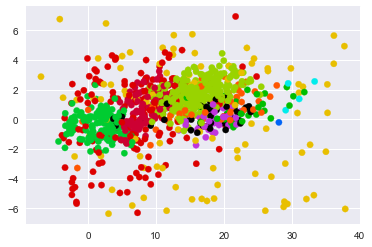

In [6]:
from helper_functions.cluster_plots import plot_gmm_scatter
n = 5000
plot_gmm_scatter(models[mod_no], df, n_samples=1000, x_var='DBZH', y_var='ZDR',cmap=dcmap)

In [19]:
df[['DBZH','ZDR']].sample(10).values

array([[  3.03999996,   0.34      ],
       [ 11.92000008,   2.63000011],
       [ 15.84000015,   2.19000006],
       [ 11.51000023,   1.52999997],
       [  6.23999977,   0.73000002],
       [ 21.28000069,  -0.56      ],
       [  2.75      ,   3.68000007],
       [ 22.65999985,   2.3900001 ],
       [ 14.14000034,   2.3900001 ],
       [ 20.34000015,   3.3900001 ]])

In [9]:
list(df)

['DBZH', 'ZDR', 'RHOHV', 'WRADH', 'KDP', 'ALT']

In [12]:
x_index_model = [i for i, s in enumerate(list(df)) if 'ALT' in s]
y_index_model = [i for i, s in enumerate(list(df)) if 'ALT' in s]

In [13]:
indices

[5]